# View on [nbviewer.jupyter.org](https://nbviewer.jupyter.org/github/icweaver/pyhat/blob/master/toymodel_gaussian.ipynb?flush_cache=true)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import pymc3 as pm
import pandas as pd
import utils
import plotutils

C:\Users\tanve\Anaconda3\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
C:\Users\tanve\Anaconda3\lib\site-packages\distributed\config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [2]:
# plot configs
%matplotlib inline
%config InlineBackend.figure_format = "retina"
plt.style.use("fivethirtyeight")

# Standard normal example

$\newcommand{\rhat}{\hat R}$
The following toy problem will help us demonstrate an improved diagnostic for MCMC convergence proposed by [Vehtari et al. (2019)](https://arxiv.org/pdf/1903.08008.pdf). This method uses the classic split-$\rhat$ metric, but in a novel way.

## Sample data

We'll start by creating some test data drawn from the standard normal distribution. This is what we will run our MCMC sampler on as a base case to highlight the problems with the current way split-$\rhat$ is used, and methods to improve it suggested by the authors.

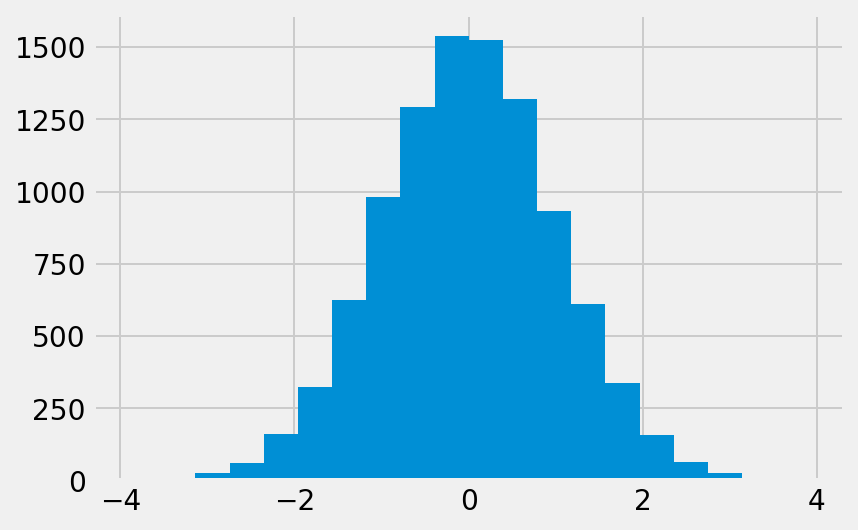

In [3]:
seed = 42
np.random.seed(seed)
data = np.random.normal(size=10_000)
plt.hist(data, bins=20)
plt.show()

## Fit with `pymc3`

Let's now fit the data $y$ with the following model to be explored by our sampler:

$$
    \mu \sim \text{Unif}[-5, 5] \\
    y|\theta \sim \mathcal N(\mu, 1)
$$

In [37]:
with pm.Model() as model:
    mu = pm.Uniform("mu", lower=-5.0, upper=5.0)
    #mu = pm.Normal("mu", 0, 1)
    y_obs = pm.Normal("y_obs", mu=mu, sigma=1.0, observed=data)

with model:
    trace = pm.sample(1_000, chains=4, tune=1_000, random_seed=seed)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]
Sampling 4 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1990.41draws/s]


We also generate a set of fake chains but instead the $\sigma = 2$ in this case. We want to see that if we replace one of the chains of the original model with the fake model, whether the traditional $\widehat{R}$ metric is able to understand this and whether the new metric can also understand this.

In [38]:
with pm.Model() as fake_model:
    mu = pm.Uniform("mu", lower=-5.0, upper=5.0)
    #mu = pm.Normal("mu", 0, 1)
    y_obs = pm.Normal("y_obs", mu=mu, sigma=2.0, observed=data)

with fake_model:
    fake_trace = pm.sample(1_000, chains=2, tune=1_000, random_seed=seed)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [mu]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:02<00:00, 1462.16draws/s]


The traces show that things are seemingly ok.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001E2A742C6A0>,
      dtype=object)

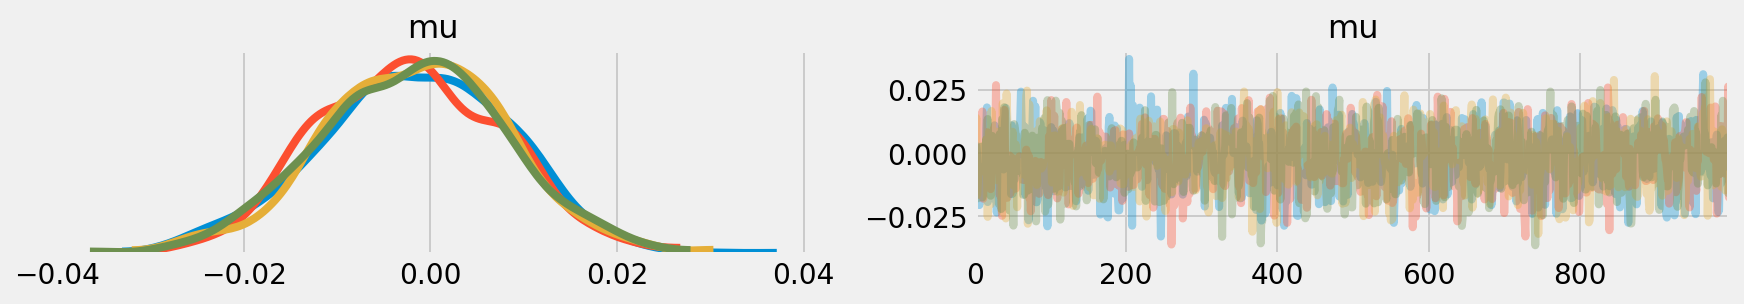

In [39]:
pm.traceplot(trace)

We can explore this in more detail by using the $\rhat$ diagnostic, defined as:

$$
\rhat = \sqrt{\frac{\widehat{\text{var}}^+(\theta|y)}{W}},\quad
\widehat{\text{var}}^+(\theta|y) = \frac{N - 1}{N}W + \frac{1}{N}B,\quad
$$

where $\widehat{\text{var}}^+(\theta|y)$ is the marginal posterior variance of the parameters $\theta$ given the data $y$, $N$ is the number of samples in our MCMC chain, and $B$ and $W$ are the standard between- and within-chain variances defined in Equations 1 and 2 of the paper, respectively. A similar, but more robust diagnostic metric, split-$\rhat$ is calculated in the same way, only the chains are split in half, doubling $M$ and halving $N$. This has the added benefit of being sensitive to non-stationary chains. 

Let's check if our implementation of the old version of $\rhat$ agree with the one baked into the popular python package, `pymc3`.

In [40]:
# compare to pymc3
param = "mu"
rhat_old = utils.rhat(trace, param, split=False)
rhat_pymc = pm.diagnostics.gelman_rubin(trace)[param]
print(param) 
print(f"rhat_old:   {rhat_old}")
print(f"rhat_pymc:  {rhat_pymc}\n")

mu
rhat_old:   1.0002369183943254
rhat_pymc:  1.0002369183943254



It looks like `pymc3` is using the standard definition for $\rhat$, which has since been outdated by the split-$\rhat$ method. Let's check that next.

In [41]:
# compare to pymc3
rhat_split = utils.rhat(trace, param, split=True)
rhat_pymc = pm.diagnostics.gelman_rubin(trace)[param]
print(param) 
print(f"rhat_split: {rhat_split}")
print(f"rhat_pymc:  {rhat_pymc}\n")

mu
rhat_split: 1.0004040443449145
rhat_pymc:  1.0002369183943254



We can see here that the split-$\rhat$ method can actually differ from the standard definition, even for a basic case like this. Let's test its robustness next by testing what happens if one of our chains happens to start in a different place in the parameter space.

# Shifted example

Using the same chains from the previous example, let's simulate the first one starting in a different place by artificially shifting it by some value $c$.

In [43]:
c = 0.0008
trace_shifted_array = np.array(trace.get_values(param, combine=False)) 
chain_1 = trace_shifted_array[0, :]
chain_1 += c
rhat_split = utils.rhat(trace_shifted_array, param, split=True)
rhat_pymc = pm.diagnostics.gelman_rubin(trace)[param]
print(param) 
print(f"rhat_split: {rhat_split}")
print(f"rhat_pymc:  {rhat_pymc}\n")

mu
rhat_split: 1.0017469740654261
rhat_pymc:  1.0002369183943254



## Different Variance Example

Now we inject one of the fake chains into our original model:

In [44]:
trace_shifted_array = np.array(trace.get_values(param, combine=False)) 
trace_shifted_array[0, :] = np.array(fake_trace.get_values(param, combine=False))[0, :]
rhat_split = utils.rhat(trace_shifted_array, param, split=True)
rhat_pymc = pm.diagnostics.gelman_rubin(trace)[param]
print(param) 
print(f"rhat_split: {rhat_split}")
print(f"rhat_pymc:  {rhat_pymc}\n")

mu
rhat_split: 1.001090996272636
rhat_pymc:  1.0002369183943254



This fake injection does not affect the traditional $\widehat{R}$ metric, and marginally changes the split metric.

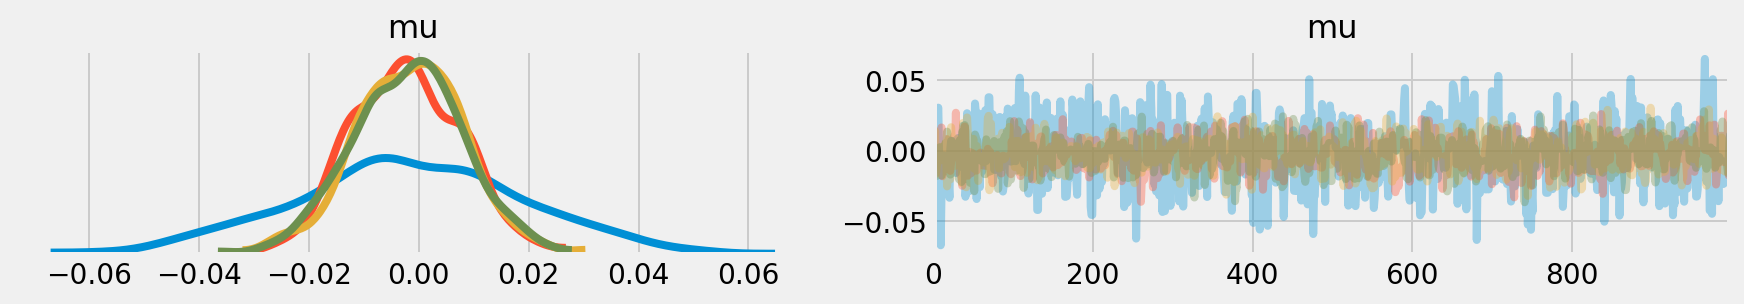

In [45]:
trace_shifted = {param:trace_shifted_array}
pm.traceplot(trace_shifted)
plt.show()

By eye, the chains look well mixed and the injected chain (blue) can look visually similar to the other chains. If we were just relying on this standard trace plot or $\rhat$ definition, we would come to the misleading conclusion that our simulation has converged for this basic toy model. The rule of thumb is that sampler results with $\rhat$ values greater than 1.01 should be treated with additional caution. 

As we see, the split-$\rhat$ fails the diagnostic threshold and the traceplot is unable to help us either. This next example will show a method to further improve the reliability of split-$\rhat$ explored in the paper.

# Rank normalized $\rhat$

This new method uses the same implementation of split-$\rhat$, but first transforms the chains before computing it. The transformation is given by Equation 6 in the text:

$$
z^{(nm)} = \Phi^{-1}\left[\frac{r^{(nm)} - 0.5}{S}\right] \quad,
$$

where $r^{(nm)}$ is the rank of $\theta^{(nm)}$, the $n$th parameter estimate of $N$ samples in the $m$th chain of $M$ total chains, and $S$ is the total number of samples drawn, and $\Phi^{-1}$ is the inverse normal transform.

First, we define function zscale that will project the traces into a standard Gaussian:

In [46]:
def zscale(trace):
    S = len(trace.flatten())
    r = utils.rank(trace.flatten())
    z = sp.stats.norm.ppf((r - 0.5) / S).reshape(trace.shape)
    return z

We test zscale to make sure it is projecting everything to a Gaussian with $\mu = 0$ and $\sigma = 1$. 

In [47]:
zscale_shifted = zscale(trace_shifted_array)

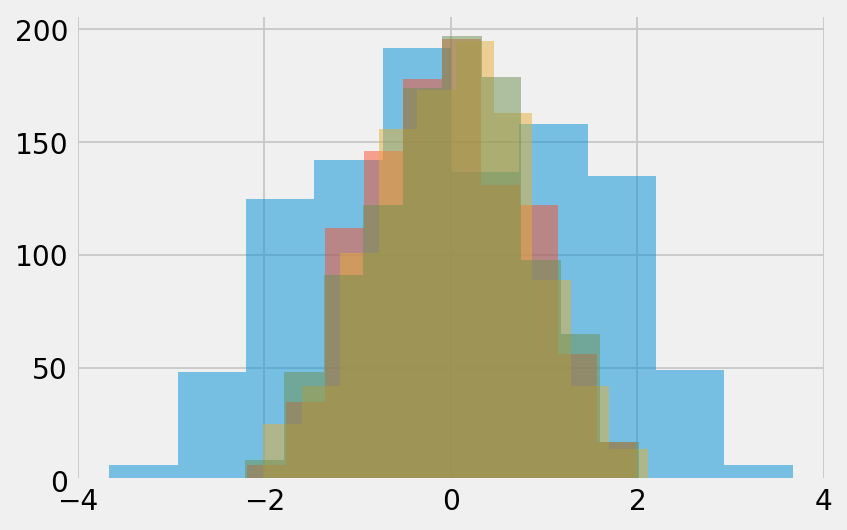

In [48]:
for i in range(4):
    plt.hist(zscale_shifted[i], alpha = 0.5);

Now, we calculate the $\widehat{R}$ metric called the *rank-normalized-$\widehat{R}$*:

In [49]:
rank_norm_rhat = utils.rhat(zscale_shifted, "mu")
rank_norm_rhat

1.0012337598024623

This value is similar to the split-$\rhat$ metric. Next, we calculate the *folded-split-$\widehat{R}$* as it measures convergence in tails. This is important because the paper suggests that we should report the maximum between the *rank-normalized-$\widehat{R}$* and the *folded-split-$\widehat{R}$*.

In [50]:
def folded_split_rhat(trace, param):
    zeta = np.abs(trace - np.median(trace).reshape(-1, 1))
    zscale_folded = zscale(zeta)
    return utils.rhat(zscale_folded, param, split = True)

In [51]:
folded_rhat = folded_split_rhat(trace_shifted_array, "mu")
folded_rhat

1.0741072299288212

We see that the maximum is $1.07$ which is much higher than both the traditional and the split $\widehat{R}$ metric. Furthermore, it is significantly larger than $1.01$, suggessting that chains have not mixed well.

To make sure that this is not a fluke, we measure both the *rank-normalized-$\rhat$* and the *folded-split-$\rhat$* from the original model. The comparison will tell us whether this metric is truly robust.

In [54]:
utils.rhat(np.array(trace.get_values(param, combine=False)), "mu")

1.0004040443449145

In [55]:
folded_split_rhat(np.array(trace.get_values(param, combine=False)), "mu")

1.0010897579525309

Here, we see that for well mixed chains, this metric indeed yields values close to $1$.

The paper additionally suggests that we look at rank plots instead of traceplots as they are more informative in telling us whether chains have **NOT** converged.

In [57]:
def rankplot(trace, nchains, rows, cols):
    """Returns rank plot for a given chain.
    Parameters
    ----------
    trace : numpy array of trace.
    nchains : number of chains to be plotted; nchains = rows * cols
    rows : number of rows in the plot
    cols: number of cols in the plot
    """
    from matplotlib.gridspec import GridSpec
    
    fig = plt.figure(figsize=(17, 10))
    gs = GridSpec(rows, cols)
    
    r = utils.rank(trace.flatten()).reshape(trace.shape)
    
    for i in range(nchains):
        ax = fig.add_subplot(gs[i])
        plt.hist(r[i], alpha = 0.8, bins = 25, histtype = 'bar', ec='black')
        ax.set_title(f"Chain : {i + 1}")

First, we plot the regular chains to see what a typical well mixed sample rankplot looks like:

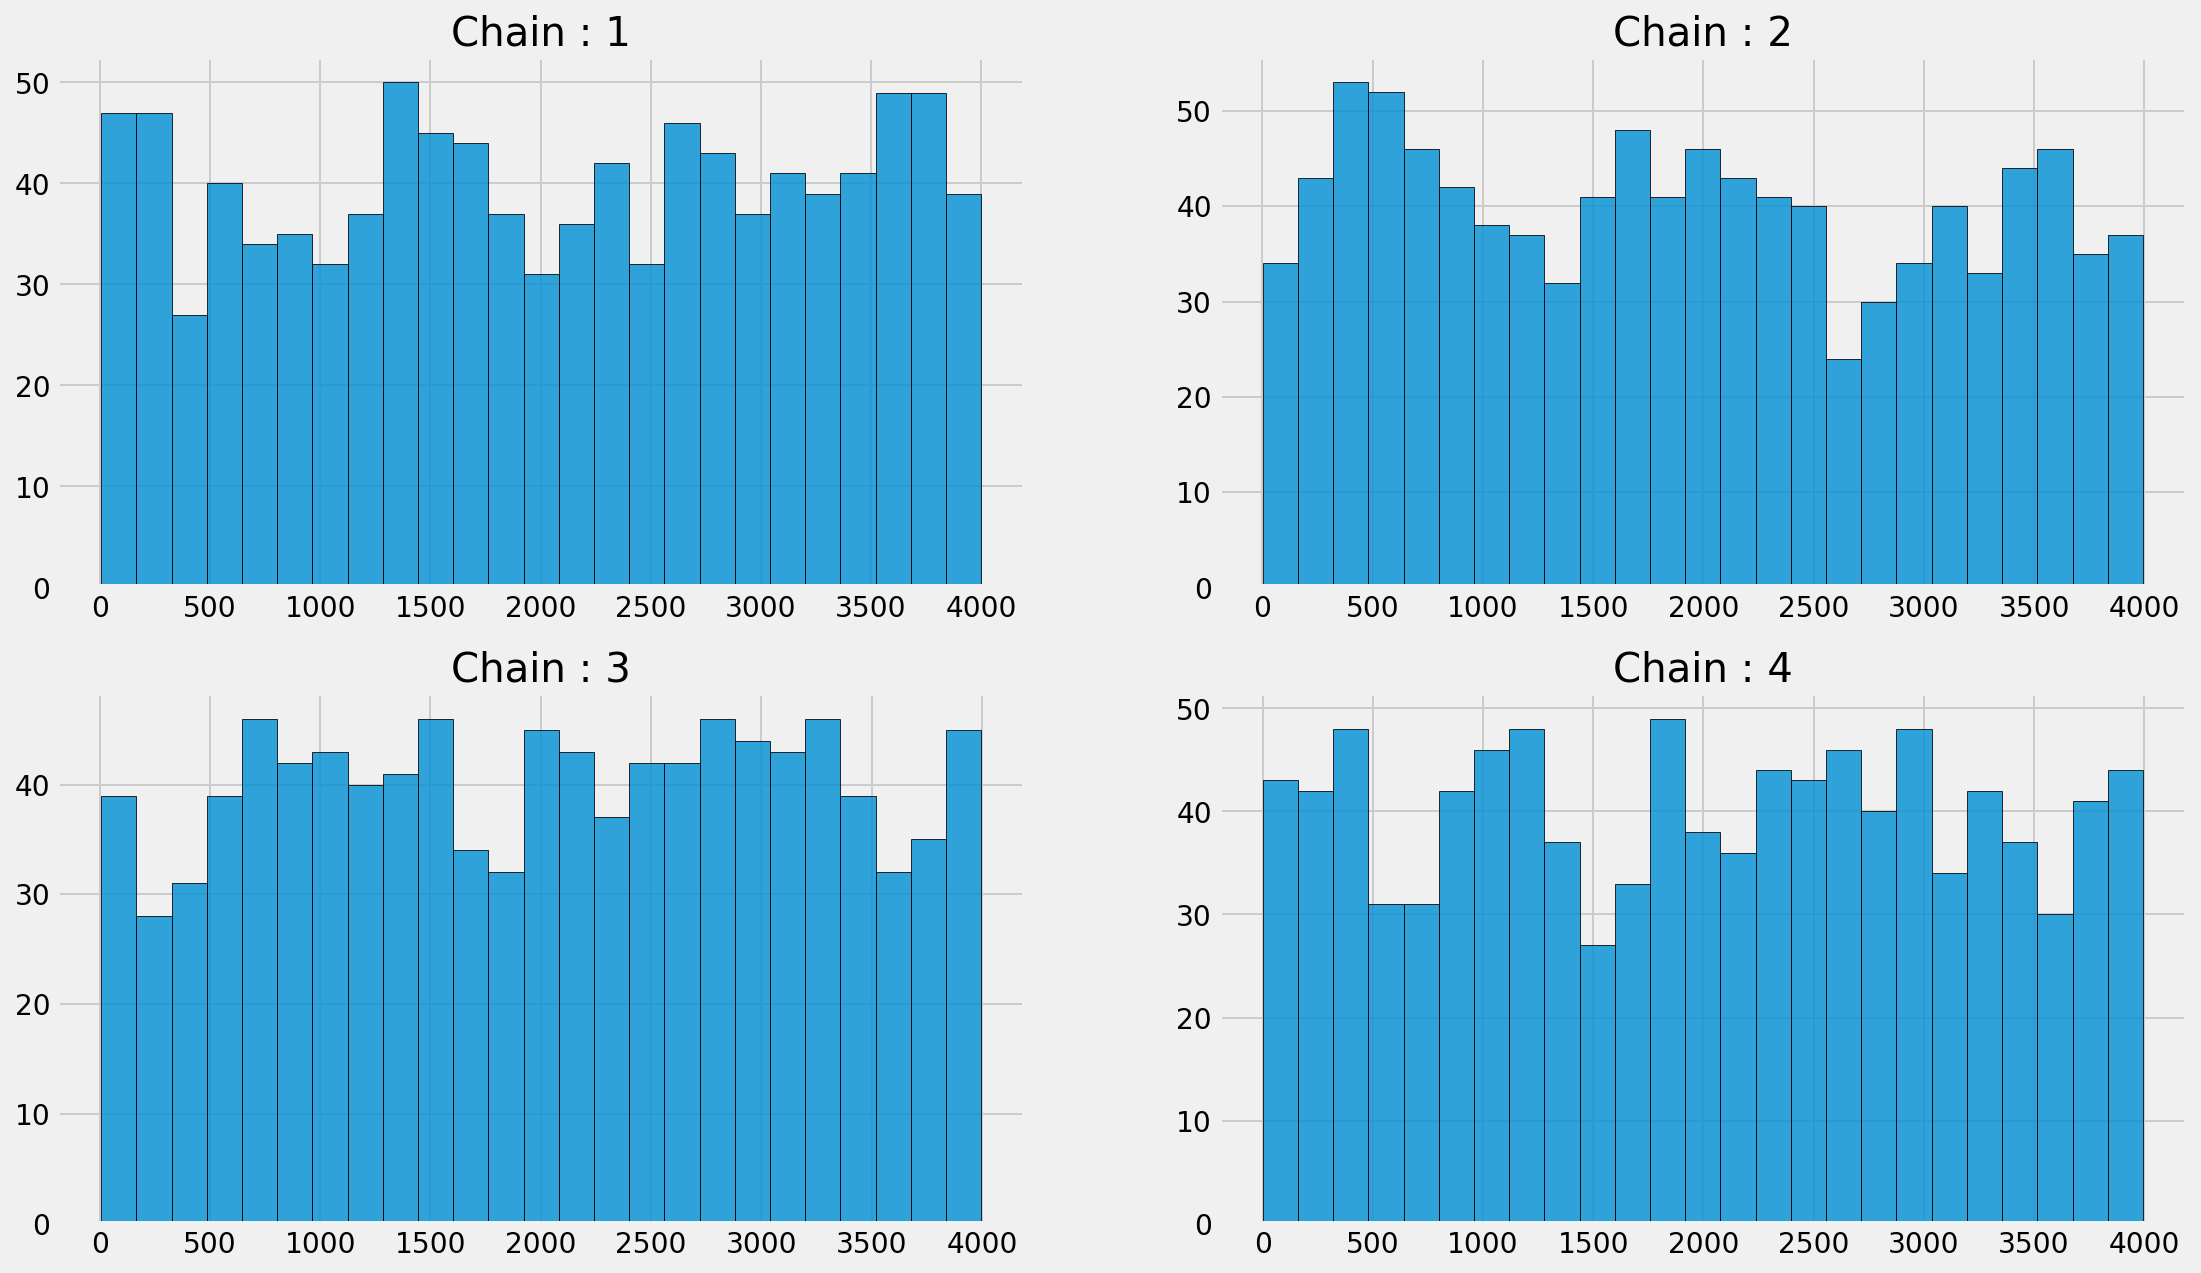

In [58]:
rankplot(np.array(trace.get_values(param, combine=False)), 4, 2, 2)

We see that qualitatively, all the chains look similar without any noticeable difference.

Next, we plot the shifted chain example:

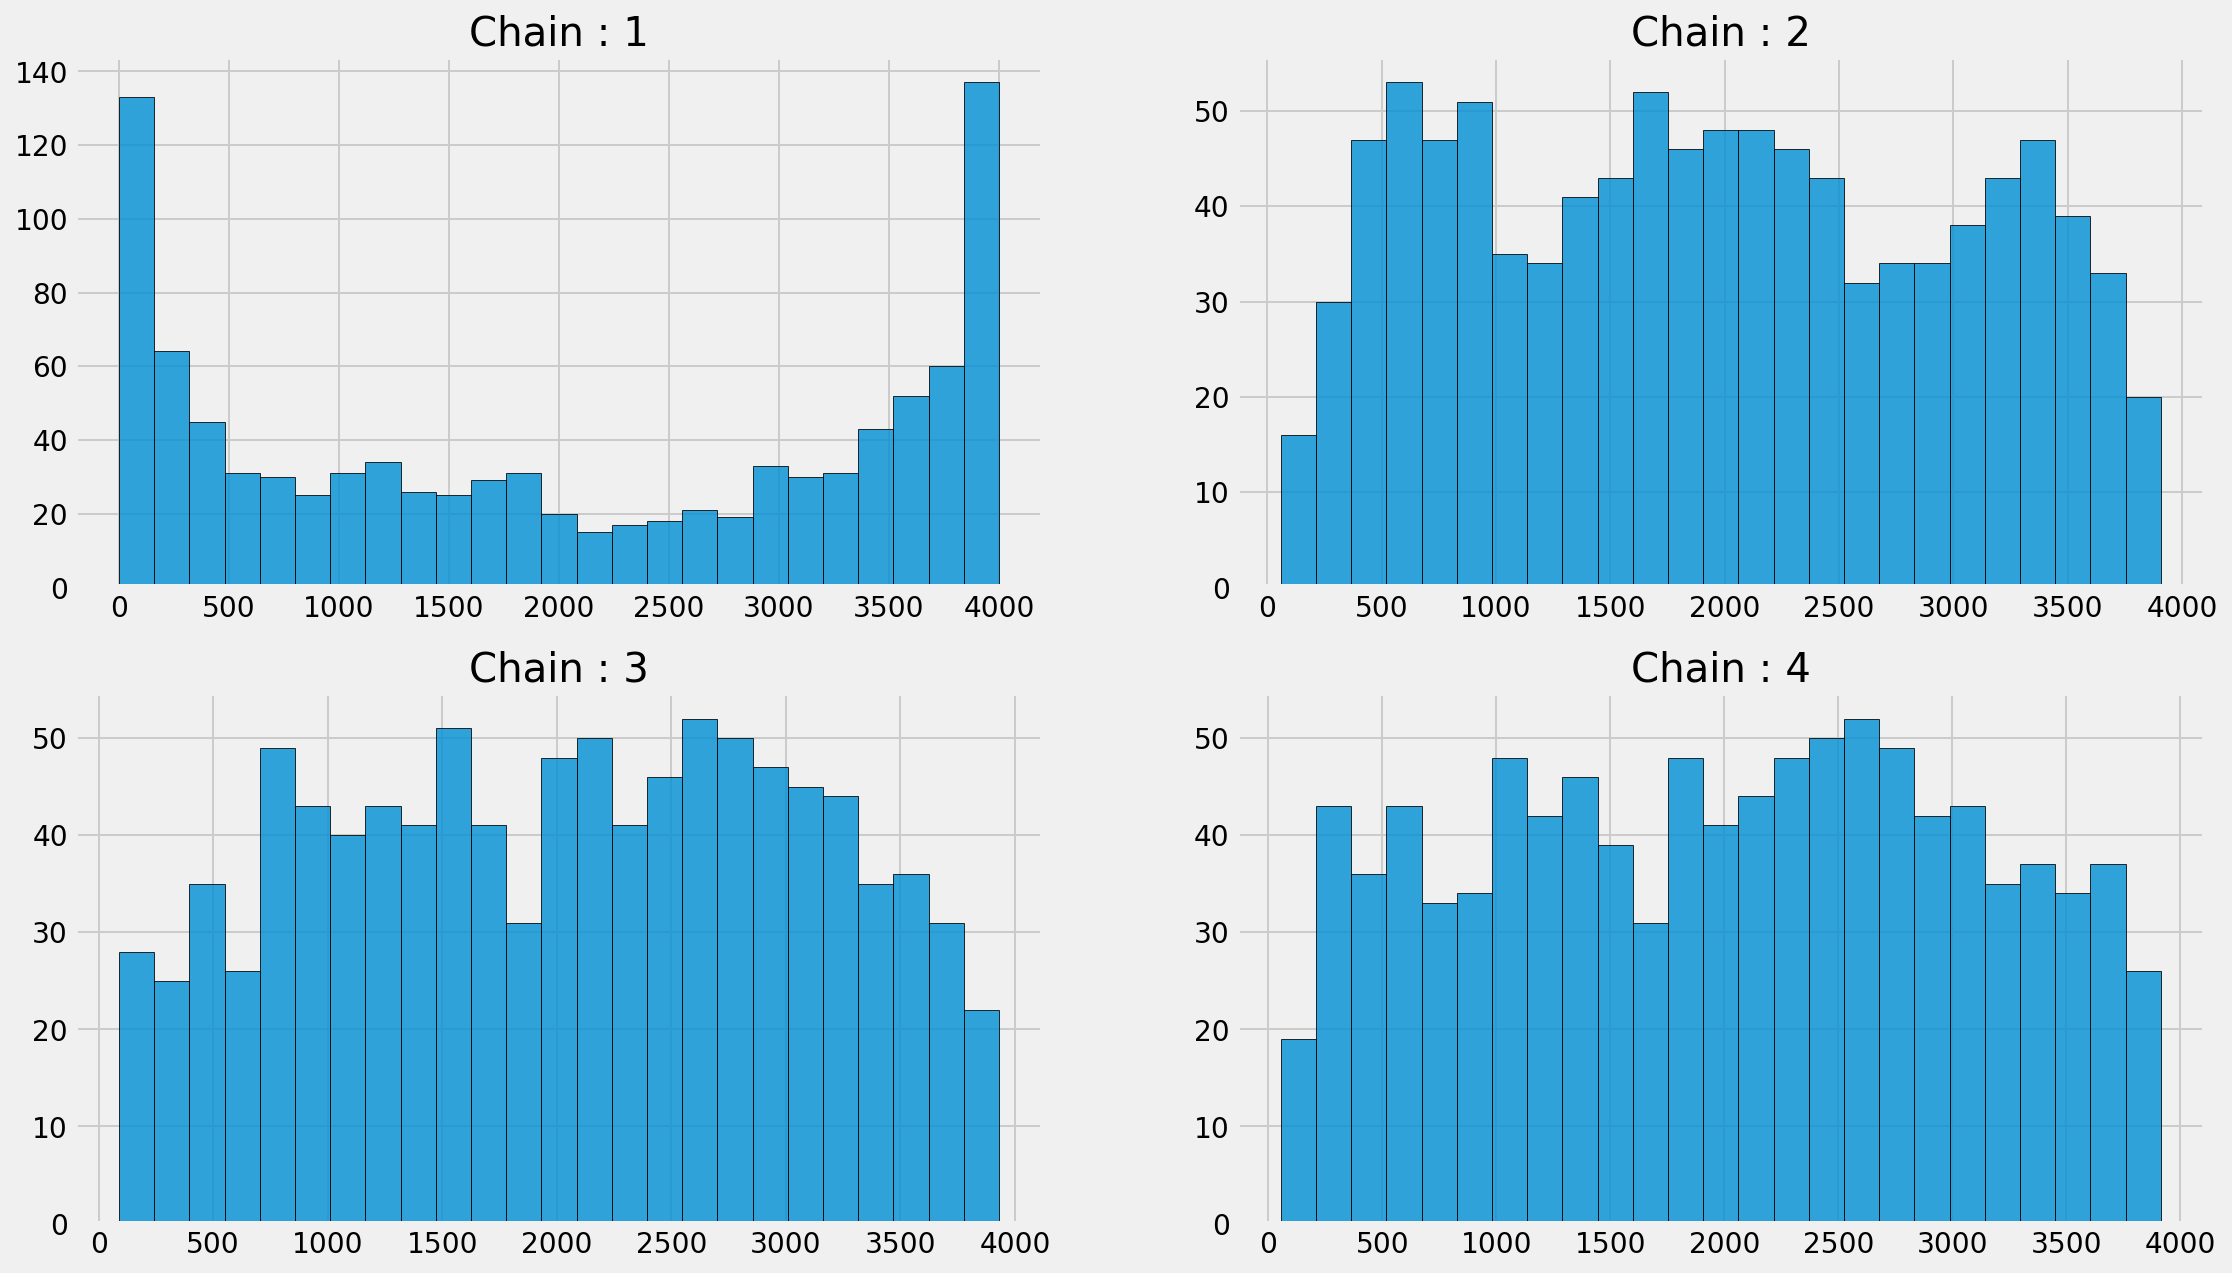

In [59]:
rankplot(trace_shifted_array, 4, 2, 2)

Clearly as it is seen, something is not right with Chain $1$. This was the chain where we injected the fake model. Hence, rank plot is more robust than traceplot at diagnosing.